In [17]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [18]:
sp = yf.download("SPY", start="2000-01-01", end="2025-01-01", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [19]:
print(sp.head())

Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2000-01-03  91.887802  93.664747  90.900610  93.664747   8164300
2000-01-04  88.294395  91.019044  88.225292  90.683399   8089800
2000-01-05  88.452354  89.419802  86.714897  88.412867  12177900
2000-01-06  87.030800  89.400059  87.030800  88.215430   6227200
2000-01-07  92.085205  92.085205  88.491829  88.649779   8066500


In [20]:
short_window = 50
long_window = 200

sp_close = pd.DataFrame(sp['Close'])

sp_close['MA_S'] = sp['Close'].rolling(short_window).mean()
sp_close['MA_L'] = sp['Close'].rolling(long_window).mean()

In [21]:
sp_close['Signal'] = 0.0
mask = sp_close['MA_L'].notna()
sp_close.loc[mask, 'Signal'] = np.where(sp_close.loc[mask, 'MA_S'] > sp_close.loc[mask, 'MA_L'], 1.0, 0.0)

sp_close['Position'] = sp_close['Signal'].diff()

close_col = sp_close.columns[0] if len(sp_close.columns) > 0 else 'SPY'

sp_close['Market_Returns'] = sp_close[close_col].pct_change()
sp_close['Strategy_Returns'] = sp_close['Market_Returns'] * sp_close['Signal'].shift(1)

valid_data = sp_close.dropna()

sp_close['Buy_Hold_Cumulative'] = (1 + sp_close['Market_Returns']).cumprod()
sp_close['Strategy_Cumulative'] = (1 + sp_close['Strategy_Returns']).cumprod()

valid_data = sp_close.dropna()

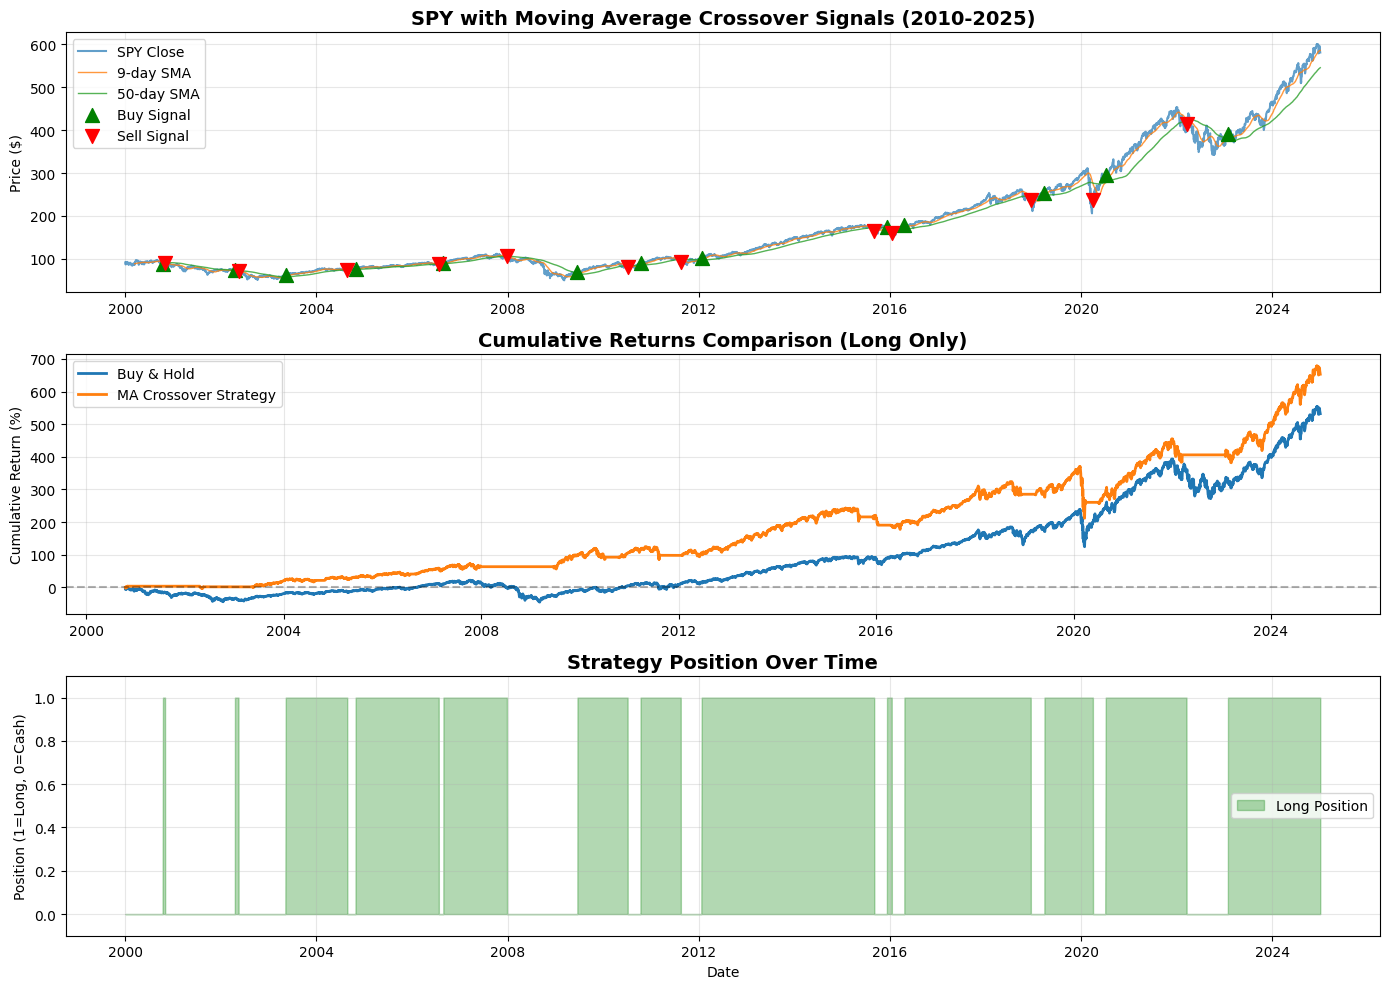

In [22]:
buy_signals = (valid_data['Position'] == 1).sum()
sell_signals = (valid_data['Position'] == -1).sum()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Price and Moving Averages
close_col = sp_close.columns[0]  # Get the close price column name
ax1.plot(sp_close.index, sp_close[close_col], label='SPY Close', alpha=0.7, linewidth=1.5)
ax1.plot(sp_close.index, sp_close['MA_S'], label='9-day SMA', alpha=0.8, linewidth=1)
ax1.plot(sp_close.index, sp_close['MA_L'], label='50-day SMA', alpha=0.8, linewidth=1)

# Mark buy/sell signals
buy_signals_data = sp_close[sp_close['Position'] == 1]
sell_signals_data = sp_close[sp_close['Position'] == -1]
ax1.scatter(buy_signals_data.index, buy_signals_data[close_col], 
           marker='^', color='green', s=100, label='Buy Signal', zorder=5)
ax1.scatter(sell_signals_data.index, sell_signals_data[close_col], 
           marker='v', color='red', s=100, label='Sell Signal', zorder=5)

ax1.set_title('SPY with Moving Average Crossover Signals (2010-2025)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Returns Comparison
ax2.plot(valid_data.index, (valid_data['Buy_Hold_Cumulative'] - 1) * 100, 
         label='Buy & Hold', linewidth=2)
ax2.plot(valid_data.index, (valid_data['Strategy_Cumulative'] - 1) * 100, 
         label='MA Crossover Strategy', linewidth=2)
ax2.set_title('Cumulative Returns Comparison (Long Only)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Return (%)')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 3: Strategy Position
ax3.fill_between(sp_close.index, 0, sp_close['Signal'], 
                 label='Long Position', alpha=0.3, color='green')
ax3.set_title('Strategy Position Over Time', fontsize=14, fontweight='bold')
ax3.set_ylabel('Position (1=Long, 0=Cash)')
ax3.set_xlabel('Date')
ax3.set_ylim(-0.1, 1.1)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
sp_close['Signal_LS'] = 0.0
mask_ls = sp_close['MA_L'].notna()

sp_close.loc[mask_ls, 'Signal_LS'] = np.where(
    sp_close.loc[mask_ls, 'MA_S'] > sp_close.loc[mask_ls, 'MA_L'], 1.0, -1.0
)

sp_close['Position_LS'] = sp_close['Signal_LS'].diff()

sp_close['Strategy_Returns_LS'] = sp_close['Market_Returns'] * sp_close['Signal_LS'].shift(1)

sp_close['Strategy_Cumulative_LS'] = (1 + sp_close['Strategy_Returns_LS']).cumprod()

valid_data_ls = sp_close.dropna()

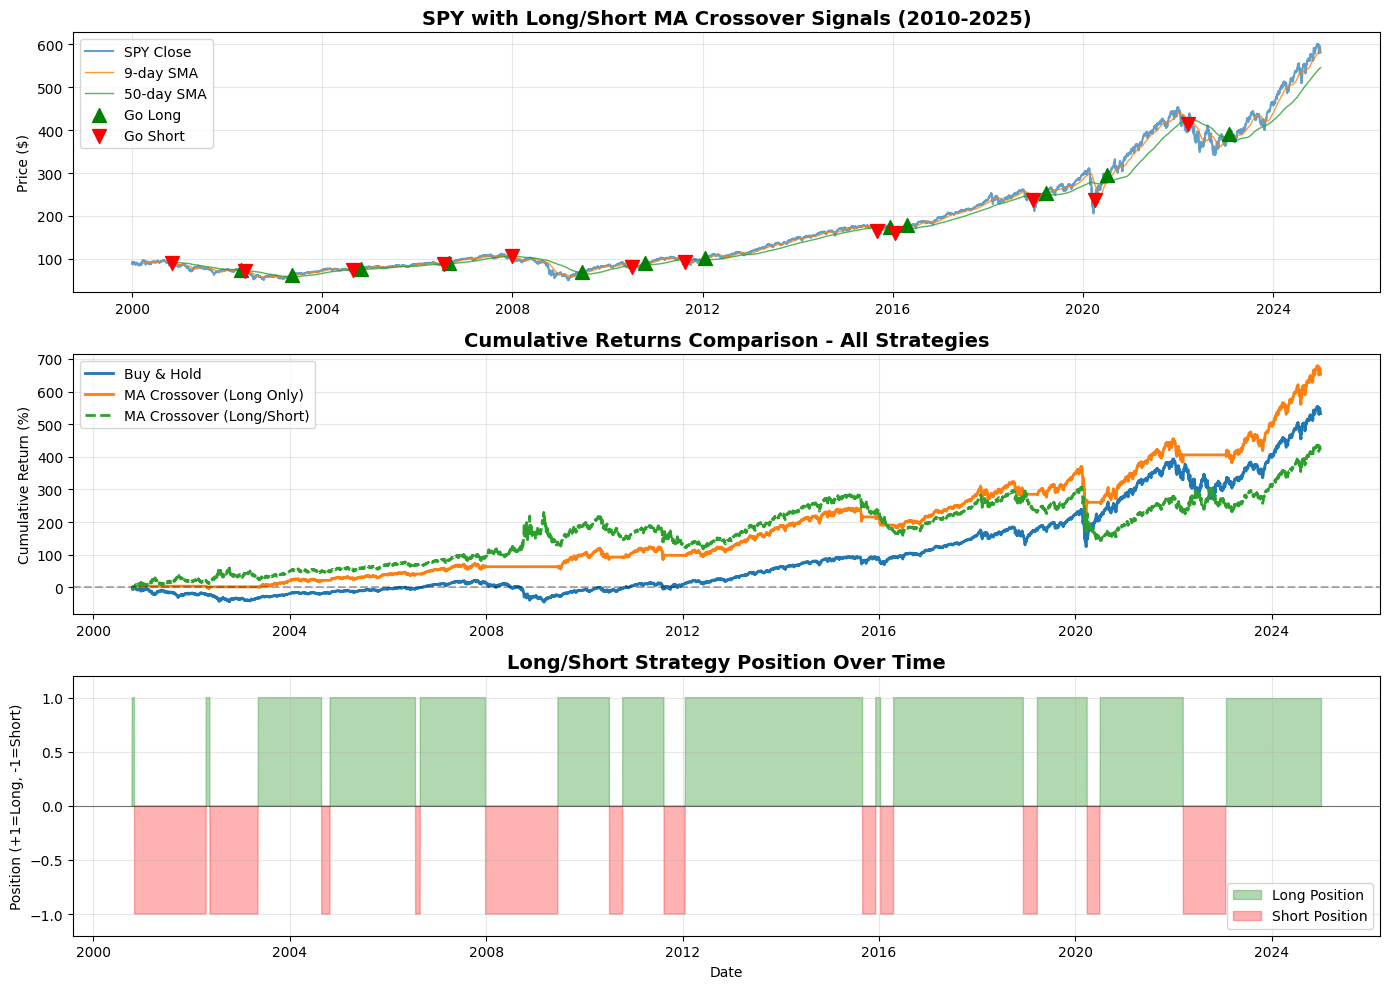

In [26]:
buy_signals_ls = (valid_data_ls['Position_LS'] == 2).sum()  
sell_signals_ls = (valid_data_ls['Position_LS'] == -2).sum()  

fig2, (ax4, ax5, ax6) = plt.subplots(3, 1, figsize=(14, 10))

# Plot 4: Price and Moving Averages with Long/Short signals
close_col = sp_close.columns[0]
ax4.plot(sp_close.index, sp_close[close_col], label='SPY Close', alpha=0.7, linewidth=1.5)
ax4.plot(sp_close.index, sp_close['MA_S'], label='9-day SMA', alpha=0.8, linewidth=1)
ax4.plot(sp_close.index, sp_close['MA_L'], label='50-day SMA', alpha=0.8, linewidth=1)

long_signals = sp_close[sp_close['Position_LS'] == 2]  # Short to long
short_signals = sp_close[sp_close['Position_LS'] == -2]  # Long to short
ax4.scatter(long_signals.index, long_signals[close_col], 
           marker='^', color='green', s=100, label='Go Long', zorder=5)
ax4.scatter(short_signals.index, short_signals[close_col], 
           marker='v', color='red', s=100, label='Go Short', zorder=5)

ax4.set_title('SPY with Long/Short MA Crossover Signals (2010-2025)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Price ($)')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# Plot 5: Cumulative Returns Comparison (All Three Strategies)
ax5.plot(valid_data_ls.index, (valid_data_ls['Buy_Hold_Cumulative'] - 1) * 100, 
         label='Buy & Hold', linewidth=2)
ax5.plot(valid_data_ls.index, (valid_data_ls['Strategy_Cumulative'] - 1) * 100, 
         label='MA Crossover (Long Only)', linewidth=2)
ax5.plot(valid_data_ls.index, (valid_data_ls['Strategy_Cumulative_LS'] - 1) * 100, 
         label='MA Crossover (Long/Short)', linewidth=2, linestyle='--')
ax5.set_title('Cumulative Returns Comparison - All Strategies', fontsize=14, fontweight='bold')
ax5.set_ylabel('Cumulative Return (%)')
ax5.legend(loc='best')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 6: Position Over Time (Long/Short)
ax6.fill_between(sp_close.index, 0, sp_close['Signal_LS'], 
                 where=(sp_close['Signal_LS'] > 0), 
                 label='Long Position', alpha=0.3, color='green', interpolate=True)
ax6.fill_between(sp_close.index, 0, sp_close['Signal_LS'], 
                 where=(sp_close['Signal_LS'] < 0), 
                 label='Short Position', alpha=0.3, color='red', interpolate=True)
ax6.set_title('Long/Short Strategy Position Over Time', fontsize=14, fontweight='bold')
ax6.set_ylabel('Position (+1=Long, -1=Short)')
ax6.set_xlabel('Date')
ax6.set_ylim(-1.2, 1.2)
ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()